# Установка библиотек


In [20]:
!pip install lightgbm
!pip install phik
!pip install -U scikit-learn

# Импорт библиотек 

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder, StandardScaler

from phik.report import plot_correlation_matrix
# from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from random import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

In [22]:
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(20,10)})

# Загрузка данных прошлой сессии 

In [23]:
total_data_ready = pd.read_csv("C:\\Users\\kikot\\Downloads\\zxcc\\zxc\\total_data_lat (1).csv")

# Доп атрибуты 

In [24]:
uniq_region = total_data_ready['region'].unique()
uniq_region

array(['Барнаул', 'Немецкий национальный район', 'Шипуновский район',
       'Чарышский район', 'Целинный район', 'Хабарский район',
       'Усть-Пристанский район', 'Усть-Калманский район',
       'Угловский район', 'Тюменцевский район', 'Троицкий район',
       'Третьсяковский район', 'Топчихинский район', 'Тогульский район',
       'Тальменский район', 'Табунский район', 'Шелаболихинский район',
       'Солтонский район', 'Солонешенский район', 'Советский район',
       'Суетский район', 'Славгородский район', 'Романовский район',
       'Родинский район', 'Ребрихинский район', 'Поспелихинский район',
       'Петропавловский район', 'Панкрушихинский район',
       'Павловский район', 'Зональный район', 'Новичихинский район',
       'Михайловский район', 'Мамонтовский район', 'Локтевский район',
       'Кытмановский район', 'Курьинский район', 'Кулундинский район',
       'Крутихинский район', 'Краснощековский район',
       'Красногорский район', 'Косихинский район', 'Ключевский рай

Смотрим количество регионов 

In [25]:
len(uniq_region)

150

Для работы с нашими данными мы создадим признаки, которые помогут решить поставленню задачу: danger_level - уровень опасности адреса, который составляется при помощи формулы, использующую сложности ДТП, количество инцидентов по региону и инцедентов по адресу; total_incidents_region - количество инцидентов по региону; total_incidents_address - количество инцидентов по адресу; severity_num - сложность ДТП в цифрах, month - месяц, в который произошло ДТП.

Ниже приведены функции, которые создадут нам описанные выше признаки:


In [26]:
def total_incidents_on_region(row):
    region = row['region']
    return total_data_ready[total_data_ready['region'] == region]['id'].count()

def total_incidents_on_address(row):
    region = row['region']
    address = row['address']
    return total_data_ready[(total_data_ready['address'] == address) & (total_data_ready['region'] == region)]['id'].count()

def severity_to_number(value):
    if value == 'Легкий':
        return 3
    elif value == 'Тяжёлый':
        return 2
    else:
        return 1

def danger_level_value(row):
    severity_num = row['severity_num']
    total_incidents_region = row['total_incidents_region']
    total_incidents_address = row['total_incidents_address']
    dead_count = row['dead_count']
    injured_count = row['injured_count']
    participants_count = row['participants_count']

    danger_level = (2**(abs(severity_num-3)) * (total_incidents_address/total_incidents_region))/total_incidents_region
    return danger_level

добавим признаки в таблицу

In [27]:
total_data_ready['total_incidents_region'] = total_data_ready.apply(total_incidents_on_region, axis=1)
total_data_ready['total_incidents_address'] = total_data_ready.apply(total_incidents_on_address, axis=1)
total_data_ready['severity_num'] = total_data_ready['severity'].apply(severity_to_number)
total_data_ready['danger_level'] = total_data_ready.apply(danger_level_value, axis=1)
total_data_ready['frequency'] = total_data_ready['total_incidents_address']/total_data_ready['total_incidents_region']

total_data_ready.head()

id                                               tags  \
0  2869171                  Дорожно-транспортные происшествия   
1  2320091  Дорожно-транспортные происшествия, ДТП и постр...   
2  2321011  Дорожно-транспортные происшествия, ДТП и постр...   
3  2576909                  Дорожно-транспортные происшествия   
4  2575209                  Дорожно-транспортные происшествия   

                 light                                             nearby  \
0  Светлое время суток                Жилые дома индивидуальной застройки   
1  Светлое время суток  Многоквартирные жилые дома, Внутридворовая тер...   
2  Светлое время суток  Административные здания, Остановка общественно...   
3  Светлое время суток  Выезд с прилегающей территории, Административн...   
4  Светлое время суток  Многоквартирные жилые дома, Жилые дома индивид...   

    region                           address   weather           category  \
0  Барнаул                     NO_INFORMATII      Ясно  Наезд на пешехода   
1  Барнаул       г Барнаул, ул Сиреневая, 11  Пасмурно       Иной вид ДТП   
2  Барнаул         г Барнаул, ул Попова, 165      Ясно  Падение пассажира   
3  Барнаул  г Барнаул, ул Петра Сухова, 83 А      Ясно       Столкновение   
4  Барнаул    г Барнаул, ул Партизанская, 26      Ясно       Столкновение   

              datetime severity  dead_count  injured_count   parent_region  \
0  2023-05-24 19:30:00   Легкий           0              1  Алтайский край   
1  2015-09-16 13:00:00   Легкий           0              1  Алтайский край   
2  2017-08-25 15:30:00   Легкий           0              1  Алтайский край   
3  2021-05-29 19:40:00  Тяжёлый           0              1  Алтайский край   
4  2021-05-25 16:40:00   Легкий           0              1  Алтайский край   

                                     road_conditions  participants_count  \
0                                              Сухое                   2   
1                                              Сухое                   2   
2                                              Сухое                   3   
3  Сухое, Отсутствие, плохая различимость горизон...                   3   
4  Сухое, Отсутствие, плохая различимость горизон...                   2   

                  participant_categories        lat       long  \
0  Все участники, Пешеходы, Мотоциклисты  53.391200  83.787900   
1                    Все участники, Дети  53.345833  83.666389   
2                    Все участники, Дети  53.197060  83.396880   
3            Все участники, Мотоциклисты  53.376400  83.714200   
4                          Все участники  53.343071  83.794366   

   total_incidents_region  total_incidents_address  severity_num  \
0                   10375                      563             3   
1                   10375                        1             3   
2                   10375                        3             3   
3                   10375                        2             2   
4                   10375                        1             3   

   danger_level  frequency  
0  5.230367e-06   0.054265  
1  9.290173e-09   0.000096  
2  2.787052e-08   0.000289  
3  3.716069e-08   0.000193  
4  9.290173e-09   0.000096

Проверяем danger_level и total_incidents_address , потому что мы составили математическую функцию и надо проверить их работоспособность 

In [28]:
total_data_ready.danger_level.describe()

count    6.802700e+04
mean     9.602265e-05
std      7.699308e-03
min      9.290173e-09
25%      1.586987e-07
50%      2.297559e-06
75%      2.514964e-05
max      2.000000e+00
Name: danger_level, dtype: float64

In [29]:
total_data_ready.total_incidents_address.describe()

count    68027.000000
mean         9.838402
std         52.877553
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        563.000000
Name: total_incidents_address, dtype: float64

Данная строка выводит строки из датафрейма total_data_ready, в которых значение столбца 'danger_level' соответствует максимальному значению этого столбца.

In [30]:
total_data_ready[total_data_ready['danger_level'] == total_data_ready['danger_level'].max()]

id                               tags                light  \
38890  2221936  Дорожно-транспортные происшествия  Светлое время суток   

                nearby       region  \
38890  Нету информации  Новая Земля   

                                                 address   weather  \
38890  Прочие автомобильные дороги (ведомственные), 1 км  Пасмурно   

            category             datetime severity  dead_count  injured_count  \
38890  Опрокидывание  2017-07-23 17:30:00  Тяжёлый           0              1   

               parent_region road_conditions  participants_count  \
38890  Архангельская область          Мокрое                   2   

      participant_categories      lat     long  total_incidents_region  \
38890          Все участники  71.5572  52.3364                       1   

       total_incidents_address  severity_num  danger_level  frequency  
38890                        1             2           2.0        1.0

Данная строка выводит статистические характеристики адресов общего количества готовых данных, где число инцидентов на этом адресе меньше 390. Выводятся такие статистические показатели, как количество значений, среднее значение, стандартное отклонение, минимальное и максимальное значения, а также значения квартилей (25%, 50% и 75%).

In [31]:
total_data_ready[total_data_ready.total_incidents_address < 390].total_incidents_address.describe()

count    67464.000000
mean         5.222163
std         15.636342
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        158.000000
Name: total_incidents_address, dtype: float64

 Нам значение 2 не нужно по причине вреда на остальные данные при составлении и обучении моделей, поэтому мы просто уберем данную строку из таблицы.

In [32]:
total_data_ready = total_data_ready.query('danger_level != 2')

Данная строка фильтрует данные в переменной total_data_ready, оставляя только те строки, где значение в столбце total_incidents_address меньше 390. 

In [33]:
total_data_ready = total_data_ready[total_data_ready.total_incidents_address < 390]

Следующий график покажет нам, насколько сильна зависимость признака severity к danger_level:

<Axes: xlabel='severity', ylabel='danger_level'>

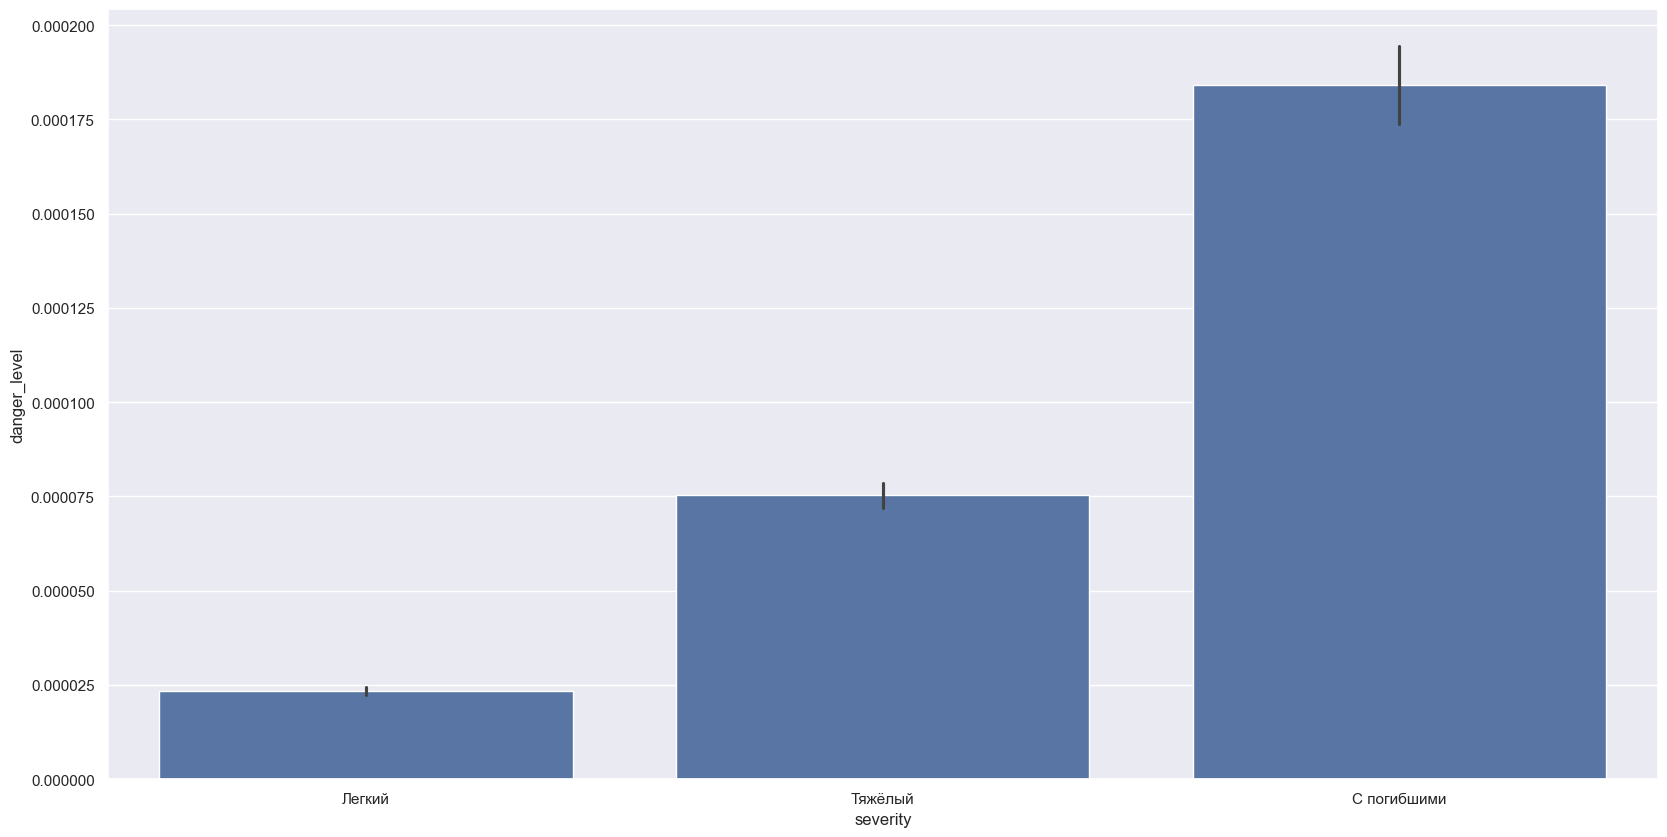

In [34]:
sns.barplot(x="severity", y="danger_level", data=total_data_ready[total_data_ready['danger_level'] < 0.006])

Чем выше тяжесть ДТП, тем выше уровень опасности дороги график с анализом самого опасного месяца

 Зависимость следующего графика такая : признак month к признаку danger_level:

In [35]:
sns.boxplot(x="month", y="danger_level", data=total_data_ready[total_data_ready['danger_level'] < 0.00015])

ValueError: Could not interpret value `month` for `x`. An entry with this name does not appear in `data`.

Самыми опасными месяцами оказался июль,август, июнь. Это полностью соответсвуют погоде, которая происходила чаще всего во время ДТП - ясная. Это еще раз доказывает нам, что чаще всего в ДТП виноваты обычные водители.

Теперь посмотрим, какая тяжесть ДТП происходила чаще по адресам:

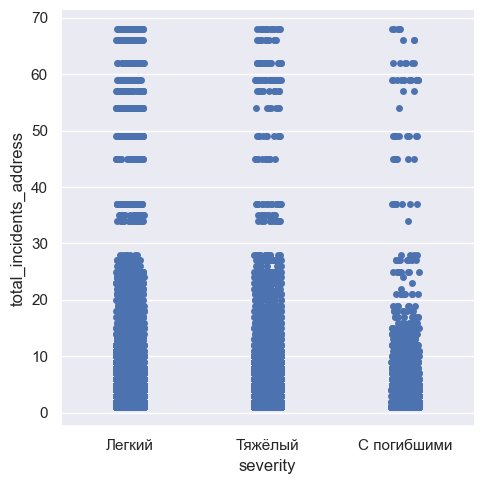

In [ ]:
sns.catplot(x="severity", y="total_incidents_address", data=total_data_ready[total_data_ready['total_incidents_address'] < 80])

Опять же, все логично - чаще всего на количество ДТП по определенным адресам происходит ДТП легкой тяжести.

Этап визуализации завершен, а значит мы можем сделать некие выводы:
Количество раненных в ДТП больше всего в тяжелом ДТП;
ДТП чаще всего происходят в ясную погоду;
Самые опасные месяцы: июль, август и июнь - 3 месяца лета.

Опять же, все логично - чаще всего на количество ДТП по определенным адресам происходит ДТП легкой тяжести.

Этап визуализации завершен, а значит мы можем сделать некие выводы:

Самые опасные месяцы: июль, август и июнь - 3 месяца лета.

# Выделение данных для кластеризации

Следующий этап - кластеризация . Кластеризация - процесс разбиения данных на кластеры

In [ ]:
cat_col = ['light','weather','category','road_conditions','participant_categories']
encoder = LabelEncoder()

total_data_ready[cat_col] = total_data_ready[cat_col].apply(encoder.fit_transform)
total_data_ready.head()

id                                               tags  light  \
1  2320091  Дорожно-транспортные происшествия, ДТП и постр...      4   
2  2321011  Дорожно-транспортные происшествия, ДТП и постр...      4   
3  2576909                  Дорожно-транспортные происшествия      4   
4  2575209                  Дорожно-транспортные происшествия      4   
5  2547743                  Дорожно-транспортные происшествия      4   

                                              nearby   region  \
1  Многоквартирные жилые дома, Внутридворовая тер...  Барнаул   
2  Административные здания, Остановка общественно...  Барнаул   
3  Выезд с прилегающей территории, Административн...  Барнаул   
4  Многоквартирные жилые дома, Жилые дома индивид...  Барнаул   
5                               Эстакада, путепровод  Барнаул   

                                             address  weather  category  \
1                        г Барнаул, ул Сиреневая, 11        7         1   
2                          г Барнаул, ул Попова, 165       21        15   
3                   г Барнаул, ул Петра Сухова, 83 А       21        16   
4                     г Барнаул, ул Партизанская, 26       21        16   
5  г Барнаул, Объездная дорога в обход г. Барнаул...       21        16   

              datetime severity  dead_count  injured_count   parent_region  \
1  2015-09-16 13:00:00   Легкий           0              1  Алтайский край   
2  2017-08-25 15:30:00   Легкий           0              1  Алтайский край   
3  2021-05-29 19:40:00  Тяжёлый           0              1  Алтайский край   
4  2021-05-25 16:40:00   Легкий           0              1  Алтайский край   
5  2021-02-22 13:50:00  Тяжёлый           0              3  Алтайский край   

   road_conditions  participants_count  participant_categories        lat  \
1             1142                   2                       8  53.345833   
2             1142                   3                       8  53.197060   
3             1274                   3                       9  53.376400   
4             1331                   2                       2  53.343071   
5              665                   4                       2  53.290476   

        long  total_incidents_region  total_incidents_address  severity_num  \
1  83.666389                   10375                        1             3   
2  83.396880                   10375                        3             3   
3  83.714200                   10375                        2             2   
4  83.794366                   10375                        1             3   
5  83.708739                   10375                       12             2   

   danger_level  frequency  
1  9.290173e-09   0.000096  
2  2.787052e-08   0.000289  
3  3.716069e-08   0.000193  
4  9.290173e-09   0.000096  
5  2.229641e-07   0.001157

Данная строка выводит количество строк и столбцов данных в переменной data_for_models.

In [ ]:
data_for_models = total_data_ready[['id', 'total_incidents_address','danger_level', 'frequency']]
print(data_for_models.shape)

(67463, 4)


In [ ]:
data_for_models.head()

id  total_incidents_address  danger_level  frequency
1  2320091                        1  9.290173e-09   0.000096
2  2321011                        3  2.787052e-08   0.000289
3  2576909                        2  3.716069e-08   0.000193
4  2575209                        1  9.290173e-09   0.000096
5  2547743                       12  2.229641e-07   0.001157

вывели 5 строк чтобы ознакомиться с содержимым 

# Кластеризация набора данных

Поэтому первым действием мы составим график локтя. График локтя это специальный метод, который показывает сколько кластеров стоит использовать. Процесс состоит в том, что при определенном количестве кластеров мы считаем сумму квадратов расстояний от элемента до ближайшего центра кластера, то есть если у нас есть всего один кластер, то расстояние от выброса до центра будет огромным, что нелогично для разделения данных по классам - нужно уменьшать расстояние до центра, но при этом не создавать слишком много классов, чтобы не терять логику этих самых классов.

Для составления локтя мы воспользуемся методом Kmeans с количеством кластеров от 1 до 10:

In [ ]:
wcss = []
for clusters in range(1, 11):

    model = KMeans(n_clusters=clusters, max_iter=300, n_init=10, random_state=45)
    model.fit(data_for_models.drop('id', axis=1))

    wcss.append(model.inertia_)

NameError: name 'data_for_models' is not defined

In [ ]:
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

NameError: name 'wcss' is not defined

На графике выше мы выделили 4 кластера, с ним и продолжим работу. Давайте инициализируем метод Kmeans с 4 кластерами и обучим его:

In [ ]:
model = KMeans(n_clusters=4, max_iter=300, n_init=10, random_state=45)
data_for_models['clusters'] = model.fit_predict(data_for_models.drop('id', axis=1))

Какие классы имеют наибольшее количество элементов

In [ ]:
data_for_models.clusters.value_counts()

 Однако давайте проверим как ситуация обстоит в уровне опасности дорог по каждому кластеров:

In [ ]:
print("Максимальный уровень опасности дороги в кластере 0:", data_for_models[data_for_models.clusters == 0]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 1:", data_for_models[data_for_models.clusters == 1]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 2:", data_for_models[data_for_models.clusters == 2]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 3:", data_for_models[data_for_models.clusters == 3]['danger_level'].max())

Самый опасный кластер - 0, самый безопасный - 3.

In [ ]:
data_for_graphic = data_for_models.copy()

In [ ]:
plt.scatter(data_for_graphic.total_incidents_address, data_for_graphic.danger_level, c=data_for_graphic.color, s=30)
plt.ylim(-0.001, 0.08)
plt.xlabel('Инциденты по адресу')
plt.ylabel('Уровень опасности дороги')

Удаляет столбец 'clusters' из датафрейма data_for_models.
Создает копию полученного датафрейма и присваивает ее переменной gaussian_data.
Выводит первые две строки полученного датафрейма.

In [ ]:
gaussian_data = data_for_models.drop('clusters', axis=1).copy()
gaussian_data.head(2)

Создание объекта модели смеси гауссовых распределений с 4 компонентами и фиксированным случайным состоянием.

Подгон модели к данным gaussian_data, за исключением столбца "id".

Прогнозирование кластеров для каждой записи в gaussian_data, за исключением столбца "id".

Подсчет количества записей в каждом кластере и вывод результата.

In [ ]:
gm = GaussianMixture(n_components=4, random_state=0).fit(gaussian_data.drop('id', axis=1))
gaussian_data['clusters'] = gm.predict(gaussian_data.drop('id', axis=1))
gaussian_data['clusters'].value_counts()

Проверим максимальные значения в каждом кластере

In [ ]:
print("Максимальный уровень опасности дороги в кластере 0:", gaussian_data[gaussian_data.clusters == 0]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 1:", gaussian_data[gaussian_data.clusters == 1]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 2:", gaussian_data[gaussian_data.clusters == 2]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 3:", gaussian_data[gaussian_data.clusters == 3]['danger_level'].max())

Самый опасный кластер - 0, самый безопасный - 2.

In [ ]:
gaussian_data_for_graphic = gaussian_data.copy()

In [ ]:
colors = [ 'red', 'yellow', 'lightgreen', 'darkgreen']#, 'lightgreen', 'yellow', 'red']
gaussian_data_for_graphic['color'] = gaussian_data_for_graphic.clusters.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})#, 4:colors[4]})

In [ ]:
plt.scatter(gaussian_data_for_graphic.total_incidents_address,
            gaussian_data_for_graphic.danger_level,
            c=gaussian_data_for_graphic.color, s=30)
plt.ylim(-0.00025, 0.02)
plt.xlabel('Инциденты по адресу')
plt.ylabel('Уровень опасности дороги')